# Potential conflicts in transatlantic flights #

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx
import tools
import progressbar
import matplotlib.backends.backend_pdf

In [2]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

rawPointConflicts = {}
pointConflicts = {}
parallelConflicts = {}
flights2Conflicts = {}
reducedPointConflicts = {}
reducedParallelConflicts = {}
multiConflicts = {}

mindistance = 30.0
mintimes = range(1,181)
delays = [1, 2, 3]
dthresholds = [1, 2, 3]
maxDepartDelays = [10, 20, 30]


for mintime in mintimes:
    name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
    
    rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
    if os.path.exists(rawPointConflictFile):
        rawPointConflicts[mintime] = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
   
    multiConflictFile = '%s.%s.multiConflicts.csv' % (inputFile, name)
    if os.path.exists(multiConflictFile):
        multiConflicts[mintime] = pd.read_csv(multiConflictFile, index_col='multiConflictIndex')
        
    pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)
    if os.path.exists(pointConflictFile):
        pointConflicts[mintime] = pd.read_csv(pointConflictFile, index_col='conflictIndex')
        
    parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
    if os.path.exists(parallelConflictFile):
        parallelConflicts[mintime] = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
        
    for delay in delays:
        for dthreshold in dthresholds:
            for maxDepartDelay in maxDepartDelays:
                flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                multiConflictFile = "%s.%s.multiConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                key = (mintime, delay, dthreshold, maxDepartDelay)
                if os.path.exists(flights2ConflictsFile):
                    flights2Conflicts[key] = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')
                if os.path.exists(reducedPointConflictFile):
                    reducedPointConflicts[key] = pd.read_csv(reducedPointConflictFile, index_col='conflictIndex')
                if os.path.exists(reducedParallelConflictFile):
                    reducedParallelConflicts[key] = pd.read_csv(reducedParallelConflictFile, index_col='parallelConflict')
                if os.path.exists(multiConflictFile):
                    multiConflicts[key] = pd.read_csv(multiConflictFile, index_col='multiConflictIndex')
        

In [3]:
parameter = (120, 3, 3, 10)

In [4]:
%matplotlib inline

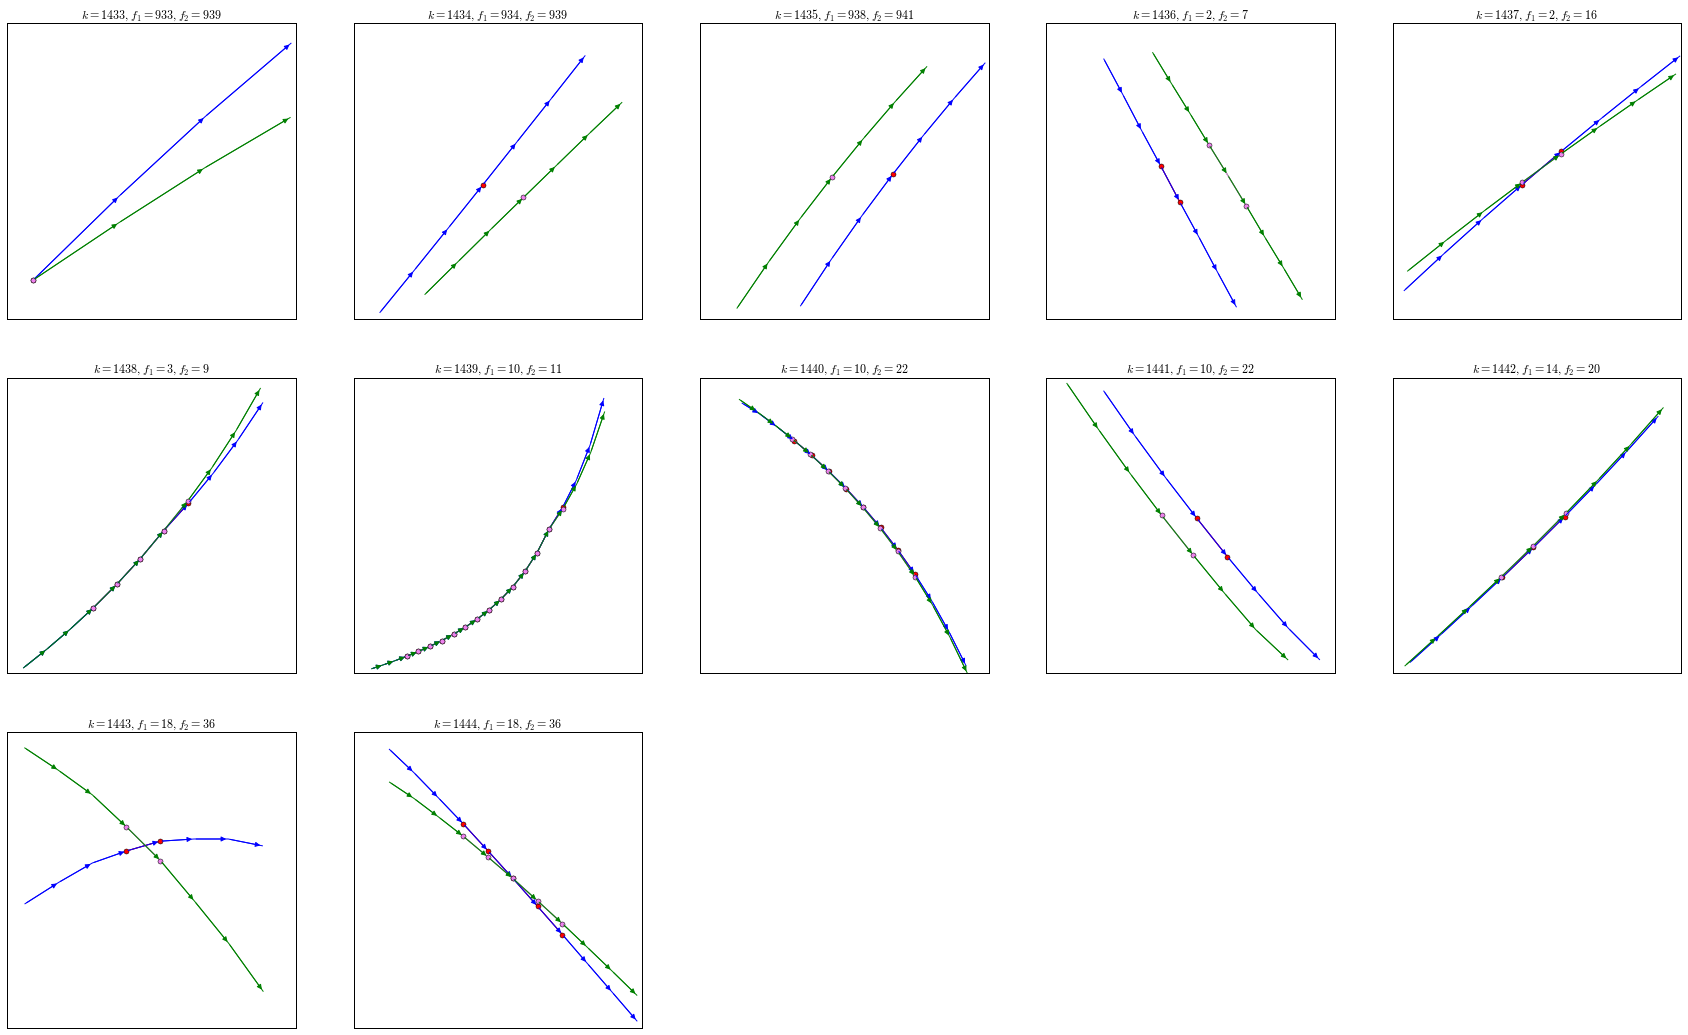

In [5]:
NconflictsPoint = len(reducedPointConflicts[parameter])
NconflictsPara = len(reducedParallelConflicts[parameter].index.unique())
conflicts = range(1433, 1445)
Nconflicts = len(conflicts)
Ncols = 5
Nrows = Nconflicts / Ncols + (Nconflicts % Ncols != 0)
fig = plt.figure(figsize=(6 * Ncols, 6 * Nrows))
for n in range(Nconflicts):
    ax = fig.add_subplot(Nrows, Ncols, n + 1)
    k = conflicts[n]
    analysis.plotConflicts([k], trajectories, reducedPointConflicts[parameter], reducedParallelConflicts[parameter], ax=ax)

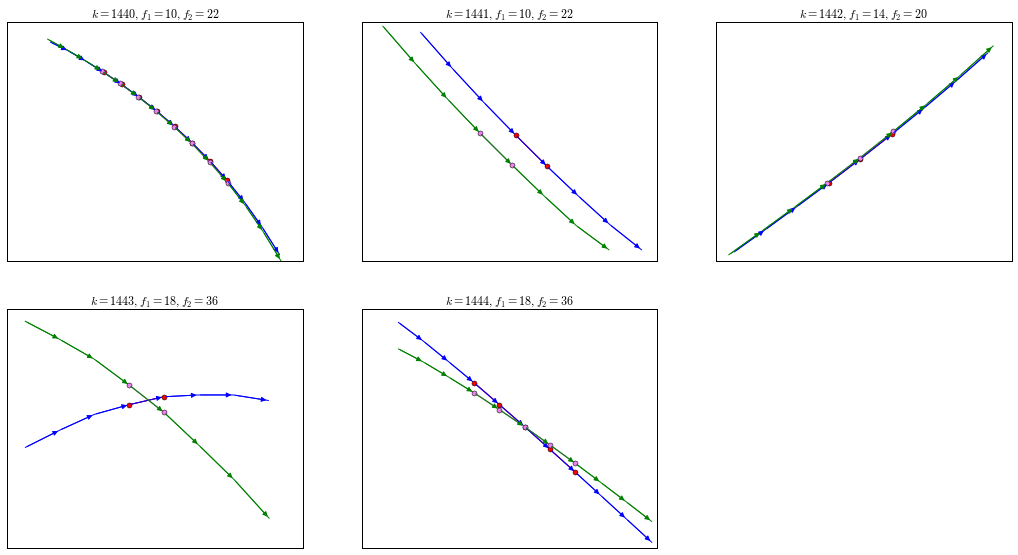

In [12]:
nperpage = 5
conflicts = range(1440, 1445)

Ncols = 3

Nconflicts = len(conflicts)
NconflictsPoint = len(reducedPointConflicts[parameter])
NconflictsPara = len(reducedParallelConflicts[parameter].index.unique())
Nrows = Nconflicts / Ncols + (Nconflicts % Ncols != 0)
pdf = matplotlib.backends.backend_pdf.PdfPages('conflicts.pdf');

for n in range(Nconflicts):
    if n % (nperpage * Ncols) == 0:
        fig = plt.figure(figsize=(6 * Ncols, 6 * nperpage));
    ax = fig.add_subplot(nperpage + 1, Ncols, n % (nperpage * Ncols) + 1)
    k = conflicts[n]
    analysis.plotConflicts([k], trajectories, reducedPointConflicts[parameter], reducedParallelConflicts[parameter], ax=ax)
    if n % (nperpage * Ncols) == (nperpage * Ncols) - 1 or n == Nconflicts - 1:
        pdf.attach_note('Conflicts');
        pdf.savefig(figure=fig);
pdf.close()